In [198]:
import os
import cv2
import random
import PIL.Image as Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Iris Biometric Identification

##### Segmentation and Recognition

## Vasil Kichukov

## Abstract


__What is Iris Biometric Identification?__

Iris biometric identification uses the unique patterns in the colored part of the eye (the iris) to identify individuals. Even the left and right irises of a person are unique. This method is highly secure and reliable, as no two people have the same iris patterns, making it one of the most accurate forms of biometric identification.

__Why is This Project Important?__

This project is important because iris recognition provides one of the most accurate ways to identify people. By developing a system that can segment the iris from the surrounding eye region, we can make the recognition process more precise and faster, which is crucial for secure applications.

__How Can This Be Used in Business?__

Iris recognition can be used in various industries for secure access, identity verification, and fraud prevention. It can improve security for businesses, banking, healthcare, and even in mobile devices, allowing for seamless and secure user experiences.

__What is the Purpose of This Project?__

The purpose of this project is to create a reliable system for accurately segmenting the iris from the eye using deep learning techniques. After segmentation, the project also focuses on recognizing the individual by comparing their segmented iris patterns to a database, allowing for secure identification and authentication. This process is essential for ensuring that the model can not only isolate the iris but also verify the identity of the person, which is crucial for applications like access control and secure transactions.

## Table of Contents

TODO

## Introduction

Iris biometric identification offers one of the most secure and accurate methods of recognizing individuals, as each person’s iris patterns are unique. Unlike other biometric traits, the iris remains stable throughout life and is extremely difficult to replicate, making it ideal for high-security applications such as banking, government, and healthcare.


Iris recognition systems are increasingly integrated into various sectors, from border control to mobile devices. These systems are growing in use due to their high accuracy and reliability. However, challenges like accurate segmentation of the iris, varying lighting conditions, and different eye shapes remain, which complicate large-scale deployment. With advancements in AI and machine learning, iris recognition technology is expected to improve in both speed and accuracy. As security needs continue to rise, iris biometric systems will likely play a critical role in personal identification and secure access in the future.

## Dataset Representation

The datasets used in this project are __IITD__ and __CASIA 1000__, which provide a rich collection of iris images for biometric identification tasks.

The __IITD dataset__ (Indian Eye Iris Dataset) was developed by the Indian Institute of Technology Delhi (IITD). It contains a total of __2240 RGB iris images__ collected from 224 individuals, with 10 images per subject. Each image in the dataset is of the size 320x240 pixels, maintaining an __aspect ratio of 4:3__. The corresponding masks for this dataset, which are used for iris segmentation, were obtained from a GitHub repository, and I would like to express my gratitude to the creators of IITD for providing the images and permission to use them for my research purposes. The images are initially in RGB format, but for this project, I converted them to grayscale to simplify processing.

The __CASIA 1000__ dataset was downloaded from Kaggle and is another significant resource for iris recognition. It contains __20,000 grayscale iris images__ from 1000 subjects, with each subject contributing 20 images — 10 images from their left eye and 10 from their right eye. The images in this dataset have a resolution of 640x480 pixels, with an __aspect ratio of 4:3__. The CASIA 1000 dataset offers a diverse set of iris images that will be invaluable for testing and validating the segmentation and recognition models.

While the images in IITD are of smaller resolution, CASIA 1000 offers a larger and more varied collection, ensuring robust model training and evaluation. The IITD dataset is primarily used in this project to create segmentation masks for the main CASIA dataset, enabling effective segmentation of the irises from the CASIA images. These segmentation masks will be crucial in training the models for iris recognition, ensuring high accuracy and reliability in real-world applications. Both datasets play a critical role in this project, enabling the development and testing of advanced segmentation and recognition algorithms for biometric iris identification.

## Iris Segmentation

In [ ]:
BASE_IMAGE_DIR = "data_masks/IITD_dataset"
BASE_MASK_DIR  = "data_masks/IITD_masks"
HEIGHT = 240
WIDTH = 320
CHANNELS = 1
ASPECT_RATIO = WIDTH/HEIGHT
SIZE = (WIDTH, HEIGHT)
SIZE_CHANNELS = (WIDTH, HEIGHT, CHANNELS)
BATCH_SIZE = 8
EPOCHS = 24

To reduce hardcoding, we'll keep everything in different variables so we can manipulate it more easily if needed.

## Reading data

In [168]:
def check_image_dimensions_dir(directory, expected_size, expected_channels):
    incorrect_dimensions = []
    
    if expected_channels == 1:
        expected_mode = 'L'
    elif expected_channels == 3:
        expected_mode = 'RGB'
    else:
        expected_mode = None
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.bmp', '.tiff',)):
                image_path = os.path.join(root, file)
                try:
                    with Image.open(image_path) as img:
                        actual_size = img.size
                        actual_mode = img.mode
                        if actual_size != expected_size or (expected_mode and actual_mode != expected_mode):
                            incorrect_dimensions.append((image_path, actual_size, actual_mode))
                except Exception as e:
                    incorrect_dimensions.append((image_path, "Error", str(e)))
                    
    if incorrect_dimensions:
        print(f"{len(incorrect_dimensions)} images with incorrect dimensions {directory}.")
        for i, (file_path, size, mode) in enumerate(incorrect_dimensions[:4]):
            print(f"{file_path} -> size: {size}, mode: {mode}")
    else:
        print(f"All images in {directory} have correct dimensions and mode.")

print("Checking BASE_IMAGE_DIR:")
check_image_dimensions_dir(BASE_IMAGE_DIR, expected_size=SIZE, expected_channels=CHANNELS)
print("\nChecking BASE_MASK_DIR:")
check_image_dimensions_dir(BASE_MASK_DIR, expected_size=SIZE, expected_channels=CHANNELS)

Checking BASE_IMAGE_DIR:
2240 images with incorrect dimensions data_masks/IITD_dataset.
data_masks/IITD_dataset\001\01.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\02.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\03.bmp -> size: (320, 240), mode: RGB
data_masks/IITD_dataset\001\04.bmp -> size: (320, 240), mode: RGB

Checking BASE_MASK_DIR:
All images in data_masks/IITD_masks have correct dimensions and mode.


The function checks whether all the images in a specified folder and its subfolders match the expected size and color channels. It loops through all images in the directory, opens them, and compares their size and mode (grayscale or RGB) with the expected values. If any images have incorrect dimensions or modes, they are listed, and the function prints the first 4 such images along with their size and mode details. If all images are correct, it simply prints a message confirming that everything is fine.

In [169]:
def map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR):
    image_to_mask_map = {}

    for folder_id in range(1, 225):
        folder_str = f"{folder_id:03d}"
        image_folder_path = os.path.join(BASE_IMAGE_DIR, folder_str)
        
        for i in range(1, 11):
            image_index_str = f"{i:02d}"
            image_filename  = f"{image_index_str}.bmp"
            full_image_path = os.path.join(image_folder_path, image_filename)
            mask_filename   = f"{folder_str}_{image_index_str}.tiff"
            full_mask_path  = os.path.join(BASE_MASK_DIR, mask_filename)
            
            if os.path.exists(full_image_path) and os.path.exists(full_mask_path):
                image_to_mask_map[full_image_path] = full_mask_path
            else:
                print(f"Missing file(s): {full_image_path} or {full_mask_path}")
    
    return image_to_mask_map

image_to_mask_map = map_images_to_masks(BASE_IMAGE_DIR, BASE_MASK_DIR)


print("\nFirst 5 (image -> mask) pairs:")
for idx, (img_path, mask_path) in enumerate(image_to_mask_map.items()):
    print(f"{idx+1}. {img_path} -> {mask_path}")
    if idx == 4:
        break


First 5 (image -> mask) pairs:
1. data_masks/IITD_dataset\001\01.bmp -> data_masks/IITD_masks\001_01.tiff
2. data_masks/IITD_dataset\001\02.bmp -> data_masks/IITD_masks\001_02.tiff
3. data_masks/IITD_dataset\001\03.bmp -> data_masks/IITD_masks\001_03.tiff
4. data_masks/IITD_dataset\001\04.bmp -> data_masks/IITD_masks\001_04.tiff
5. data_masks/IITD_dataset\001\05.bmp -> data_masks/IITD_masks\001_05.tiff


We create a dictionary that links image file paths to their corresponding mask file paths. It loops through the image and mask directories, checks if the files exist, and maps each image to its mask. The function returns the dictionary containing all valid image-mask pairs.

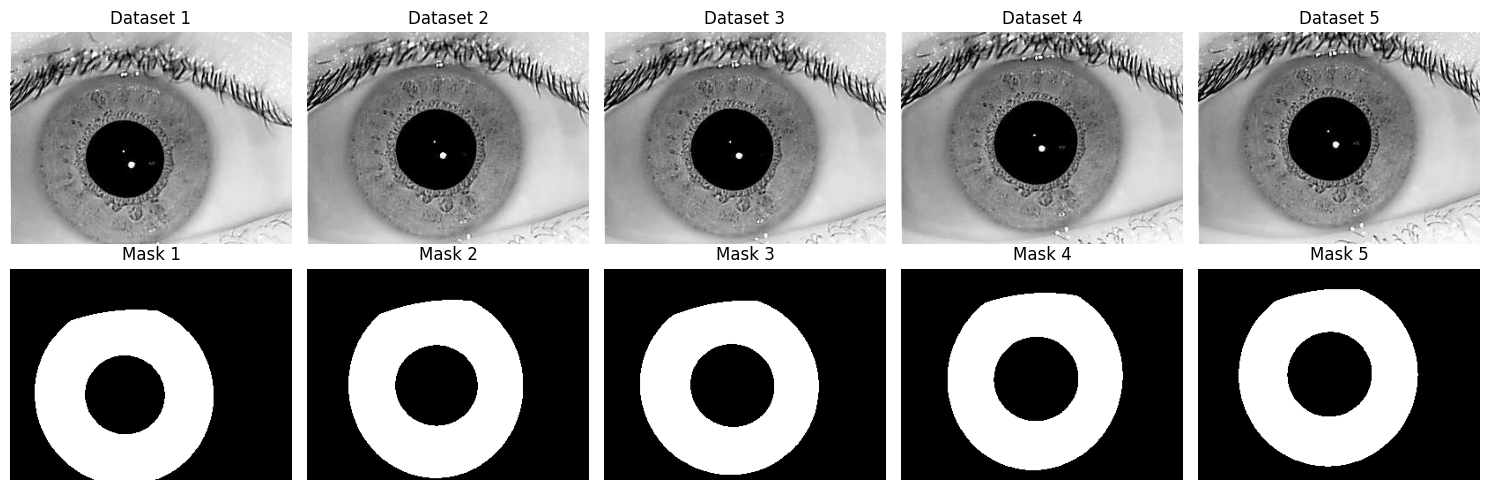

In [170]:
def visualize_images_from_dict(image_to_mask_map, num_images=5):
    selected_pairs = list(image_to_mask_map.items())[:num_images]
    plt.figure(figsize=(15, 5))  
    
    for i, (img_path, mask_path) in enumerate(selected_pairs):
        img = Image.open(img_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Dataset {i+1}")
        plt.axis('off')
        
        mask_img = Image.open(mask_path)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(mask_img, cmap='gray')
        plt.title(f"Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images_from_dict(image_to_mask_map, num_images=5)

## Preprocessing

In [171]:
def split_dataset(image_to_mask_map, train_ratio=0.8):
    pairs = list(image_to_mask_map.items())
    random.shuffle(pairs)
    split_idx = int(train_ratio * len(pairs))
    
    train_pairs = pairs[:split_idx]
    val_pairs   = pairs[split_idx:]
    
    return train_pairs, val_pairs

train_pairs, val_pairs = split_dataset(image_to_mask_map, train_ratio=0.8)

# Optionally print the split sizes to check
print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")


Train pairs: 1792
Validation pairs: 448


We split the dataset of image-mask pairs into training and validation sets based on the specified train_ratio. It first shuffles the image-mask pairs to ensure a random split, then divides the shuffled pairs into two sets: one for training and the other for validation. The training set contains train_ratio (default 80%) of the total pairs, and the remaining pairs are allocated to the validation set. The function returns the two sets: train_pairs and val_pairs

In [172]:
def load_image_mask(image_path, mask_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    img_norm = (img.astype(np.float32)) / 255.0
    msk_bin = (msk > 127).astype(np.float32)
    
    # Expand dims: (240,320) -> (240,320,1)
    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin,  axis=-1)
    
    return img_norm, msk_bin

The function loads an image and its corresponding mask from the specified file paths. Although the image files are originally in RGB format, the function reads them as grayscale using OpenCV. The image is then normalized to the range [0, 1] by dividing its pixel values by 255, and the mask is binarized by setting pixels above a threshold of 127 to 1 (foreground) and below to 0 (background). After processing, both the image and the mask are expanded to have an extra dimension (making them 3D arrays, i.e., (height, width, 1)) to match the input shape required by the model. The function then returns the transformed grayscale image and its corresponding mask.

In [173]:
def data_generator(pairs_list, batch_size=BATCH_SIZE):
    while True:
        random.shuffle(pairs_list)
        for i in range(0, len(pairs_list), batch_size):
            batch_pairs = pairs_list[i : i+batch_size]
            
            images = []
            masks  = []
            
            for (img_path, msk_path) in batch_pairs:
                img_arr, msk_arr = load_image_mask(img_path, msk_path)
                images.append(img_arr)
                masks.append(msk_arr)
            
            images = np.array(images, dtype=np.float32)  # shape=(B,240,320,1)
            masks  = np.array(masks,  dtype=np.float32)  # shape=(B,240,320,1)
            
            yield (images, masks)

Generator yields batches of image-mask pairs for training a model. It continuously loops through the provided list of image-mask pairs (pairs_list), shuffles them, and splits them into batches of a specified size (batch_size). For each batch, it loads the corresponding images and masks using the load_image_mask function, processes them into grayscale format, normalizes the images, and binarizes the masks. The images and masks are then converted to NumPy arrays with a shape of (batch_size, height, width, 1) to match the model's input requirements. The function yields these batches of processed images and masks indefinitely for training.

## U-net - custom model

In [175]:
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

The Dice coefficient is used for segmentation because it effectively measures the overlap between the predicted mask and the ground truth mask. Unlike accuracy, which can be misleading in cases of imbalanced datasets, the Dice coefficient focuses on how well the model captures the iris area by comparing the true positive pixels in both the predicted and actual masks.

In [174]:
def get_early_stopping_callback():
    return tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2, 
        restore_best_weights=True
    )

EarlyStopping callback monitors the validation loss during training. If the validation loss doesn't improve for 2 consecutive epochs (patience=2), training stops early and the best model weights are restored.

In [176]:
def create_unet(input_shape=(240,320,1)):
    inputs = layers.Input(shape=input_shape)

    # Downsampling
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c3)

    # Upsampling
    u4 = layers.UpSampling2D((2,2))(c3)
    concat4 = layers.concatenate([u4, c2], axis=-1)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(concat4)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2,2))(c4)
    concat5 = layers.concatenate([u5, c1], axis=-1)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(concat5)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c5)

    # Output layer: 1 channel with sigmoid
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

The __U-Net architecture__ is a popular model for image segmentation tasks. It consists of two main parts: downsampling (contracting path) and upsampling (expansive path).

__Downsampling__ (Contracting Path): This part extracts features from the input image using convolutional layers with ReLU activation and max-pooling layers for downsampling. It captures spatial hierarchies of the image.

The first convolution block (c1) has two convolutional layers with 32 filters, followed by a max-pooling operation.
The second block (c2) uses 64 filters and also follows the same pattern.
The third block (c3) has 128 filters and serves as the bottleneck of the network, where the most abstract features are captured.

__Upsampling__ (Expansive Path): This part rebuilds the segmented output using up-sampling layers followed by convolutions. It combines the features from earlier layers using skip connections (concatenation) to preserve high-resolution details. U4 and u5 are upsampling layers, each followed by convolution blocks (c4, c5) to refine the segmentation.

Output Layer: The final layer produces a single channel output (grayscale), using a sigmoid activation for pixel-wise classification (foreground or background). The sigmoid activation ensures that the model outputs a probability map, where values closer to 1 represent foreground (iris) and values closer to 0 represent the background.

In [177]:
# Assuming `data_generator`, `train_pairs`, `val_pairs`, `BATCH_SIZE`, and `dice_metric` are defined elsewhere
train_gen = data_generator(train_pairs, batch_size=BATCH_SIZE)
val_gen = data_generator(val_pairs, batch_size=BATCH_SIZE)

# Create U-Net model
model = create_unet(input_shape=(240, 320, 1))
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[dice_metric]
)

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 240, 320, 1)]        0         []                            
                                                                                                  
 conv2d_218 (Conv2D)         (None, 240, 320, 32)         320       ['input_15[0][0]']            
                                                                                                  
 conv2d_219 (Conv2D)         (None, 240, 320, 32)         9248      ['conv2d_218[0][0]']          
                                                                                                  
 max_pooling2d_44 (MaxPooli  (None, 120, 160, 32)         0         ['conv2d_219[0][0]']          
 ng2D)                                                                                     

The model is compiled using the Adam optimizer, which adapts the learning rate based on training, and the binary cross-entropy loss function, suitable for binary segmentation tasks (iris vs. background).

In [178]:
steps_per_epoch  = len(train_pairs) // BATCH_SIZE
validation_steps = len(val_pairs)   // BATCH_SIZE

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=get_early_stopping_callback()
)

Epoch 1/24
224/224 [==============================] - 561s 2s/step - loss: 0.2901 - dice_metric: 0.6581 - val_loss: 0.1822 - val_dice_metric: 0.8482
Epoch 2/24
224/224 [==============================] - 540s 2s/step - loss: 0.1184 - dice_metric: 0.8859 - val_loss: 0.0953 - val_dice_metric: 0.9147
Epoch 3/24
224/224 [==============================] - 539s 2s/step - loss: 0.0839 - dice_metric: 0.9195 - val_loss: 0.1159 - val_dice_metric: 0.8910
Epoch 4/24
224/224 [==============================] - 536s 2s/step - loss: 0.0751 - dice_metric: 0.9280 - val_loss: 0.0650 - val_dice_metric: 0.9383
Epoch 5/24
224/224 [==============================] - 555s 2s/step - loss: 0.0646 - dice_metric: 0.9374 - val_loss: 0.0657 - val_dice_metric: 0.9384
Epoch 6/24
224/224 [==============================] - 557s 2s/step - loss: 0.0628 - dice_metric: 0.9394 - val_loss: 0.0644 - val_dice_metric: 0.9420
Epoch 7/24
224/224 [==============================] - 555s 2s/step - loss: 0.0562 - dice_metric: 0.9455 - 

The training shows steady progress in both loss reduction and improvement in segmentation quality. The model is learning effectively on the training set while maintaining a good generalization to the validation set. 

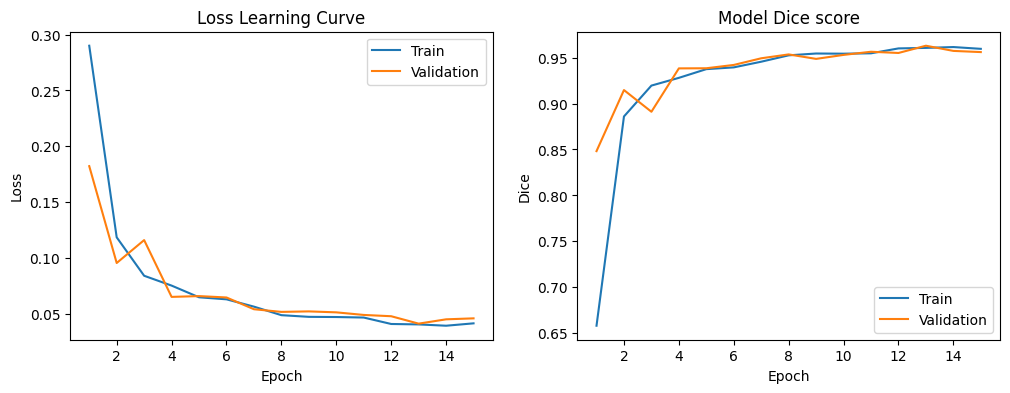

In [180]:
def plot_learning_curves(history):
    train_loss = history.history['loss']
    val_loss   = history.history['val_loss']
    
    train_dice = history.history['dice_metric']
    val_dice   = history.history['val_dice_metric']
    
    epochs_range = range(1, len(train_loss)+1)
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Train')
    plt.plot(epochs_range, val_loss, label='Validation')
    plt.title('Loss Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_dice, label='Train')
    plt.plot(epochs_range, val_dice, label='Validation')
    plt.title('Model Dice score')
    plt.ylabel('Dice')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.show()

plot_learning_curves(history)

__Overfitting__: There isn't a clear sign of overfitting, as the training and validation curves are fairly close. However, some fluctuations in the validation loss and Dice score suggest that the model might slightly overfit towards the end of training.

__Convergence__: Both the loss and Dice metrics are leveling out after around 10 epochs, which indicates that the model has likely reached its optimal performance on the given data. Further epochs will not result in improvements.

__Model Performance__: The model's ability to segment the iris seems to be strong, with a validation Dice score approaching 0.95 and a validation loss that's quite low, suggesting good segmentation performance on unseen data.

In [181]:
def create_overlay(original_path, pred_mask, alpha=0.4):
    pred_mask = pred_mask.squeeze(axis=-1)

    orig = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
    orig_color = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
    
    green_mask = np.zeros_like(orig_color)
    green_mask[...,1] = (pred_mask * 255).astype(np.uint8)

    overlay = cv2.addWeighted(orig_color, 1.0, green_mask, alpha, 0)
    return overlay

We create an image overlay where the predicted mask is displayed on top of the original image. It first reads the original image and converts it to a color format. Then, it creates a green mask from the predicted mask and overlays it on the original image with a specified transparency (alpha). The resulting image shows the original iris image with the predicted mask highlighted in green.

Found 1 poorly segmented images (dice < 0.7):
data_masks/IITD_dataset\003\01.bmp => dice=0.358


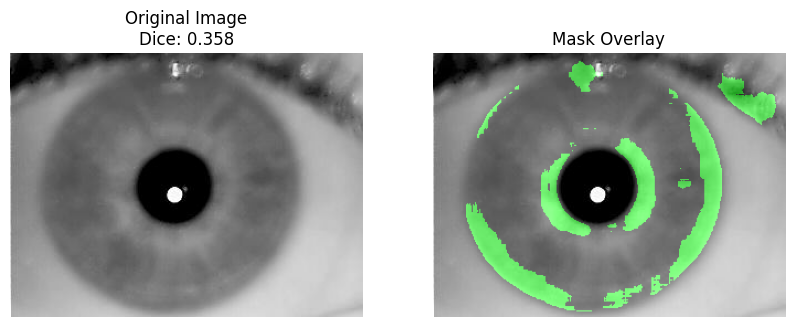

In [183]:
def evaluate_segmentation_per_image(pairs_list, model, threshold=0.5, dice_threshold=0.7):
    poorly_segmented = []
    
    for (img_path, msk_path) in pairs_list:
        img_arr, msk_arr = load_image_mask(img_path, msk_path)

        pred = model.predict(np.expand_dims(img_arr, axis=0), verbose=0)
        pred_2d = pred[0, ..., 0]  
        pred_bin = (pred_2d > threshold).astype(np.float32)

        y_true_f = msk_arr.flatten()
        y_pred_f = pred_bin.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        dice = (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-6)

        if dice < dice_threshold:
            poorly_segmented.append((img_path, dice, pred_bin))

    if poorly_segmented:
        print(f"Found {len(poorly_segmented)} poorly segmented images (dice < {dice_threshold}):")

        for img_path, dice_val, pred_mask in poorly_segmented:
            print(f"{img_path} => dice={dice_val:.3f}")

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            pred_mask_for_overlay = cv2.resize(
                pred_mask, 
                (img.shape[1], img.shape[0]),  # (width, height) in OpenCV
                interpolation=cv2.INTER_NEAREST
            )

            green_mask = np.zeros_like(img_color)
            green_mask[..., 1] = (pred_mask_for_overlay * 255).astype(np.uint8)

            overlay = cv2.addWeighted(img_color, 1.0, green_mask, 0.5, 0)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img_color, cmap='gray')
            plt.title(f"Original Image\nDice: {dice_val:.3f}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(overlay)
            plt.title("Mask Overlay")
            plt.axis('off')

            plt.show()
    else:
        print("All images have a higher score than the dice threshold.")


poorly_segmented_images = evaluate_segmentation_per_image(val_pairs, model, threshold=0.5, dice_threshold=0.70)

The function checks each image's Dice score. If the score is below the specified threshold (default 0.7), the image is considered poorly segmented. The function prints the image path, Dice score, and displays an overlay of the predicted mask on the original image for inspection. Only one image had a low Dice score of 0.358, and it will display the overlay for review.

### U-net - Implementation from a Paper

In [184]:
IMG_HEIGHT = 572
IMG_WIDTH = 572
BATCH_SIZE = 4
FINAL_MASK_SIZE = 388
MASK_CROP = FINAL_MASK_SIZE

In [185]:
def center_crop_2d(array_2d, target_size):
    """Crop a 2D array to target_size x target_size from the center."""
    h, w = array_2d.shape
    start_y = (h - target_size) // 2
    start_x = (w - target_size) // 2
    return array_2d[start_y:start_y+target_size, start_x:start_x+target_size]

In [186]:
def load_image_mask(image_path, mask_path):
    """
    Reads image & mask, resizes both to 572x572,
    THEN crops the mask to e.g. 388x388 in the center.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)

    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    msk_resized = cv2.resize(msk, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)

    msk_cropped = center_crop_2d(msk_resized, MASK_CROP)

    img_norm = img_resized.astype(np.float32) / 255.0
    msk_bin  = (msk_cropped > 127).astype(np.float32)

    # Expand dimensions => (H, W, 1)
    img_norm = np.expand_dims(img_norm, axis=-1)
    msk_bin  = np.expand_dims(msk_bin,  axis=-1)

    return img_norm, msk_bin

In [187]:
class CropToMatch(layers.Layer):
    """
    Dynamically crop 'source' so that height/width match 'target'.
    Used in the valid-padding skip connections.
    """
    def call(self, inputs):
        source, target = inputs
        s = tf.shape(source)
        t = tf.shape(target)

        height_diff = s[1] - t[1]
        width_diff  = s[2] - t[2]

        crop_top  = height_diff // 2
        crop_left = width_diff  // 2

        return tf.slice(
            source,
            [0, crop_top, crop_left, 0],
            [-1, s[1] - crop_top*2, s[2] - crop_left*2, -1]
        )


In [188]:
def unet_paper(
    input_shape=(572,572,1),
    num_classes=1,
    initial_filters=64,
    final_activation='sigmoid'
):
    """
    Classic unpadded U-Net. The final output is smaller (e.g., ~388x388).
    We'll measure that shape at runtime, but we won't feed the model a mask
    bigger than that, so we crop the mask to e.g. 388x388 in the data loader.
    """
    inputs = layers.Input(shape=input_shape)

    # Contracting path
    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(inputs)
    c1 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(p1)
    c2 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(p2)
    c3 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(p3)
    c4 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

    # Bottom
    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(p4)
    c5 = layers.Conv2D(initial_filters*16, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c5)

    # Expansive path
    u6 = layers.Conv2DTranspose(initial_filters*8, (2,2), strides=2, kernel_initializer='he_normal')(c5)
    c4_crop = CropToMatch()([c4, u6])
    merge6  = layers.concatenate([u6, c4_crop], axis=-1)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(merge6)
    c6 = layers.Conv2D(initial_filters*8, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c6)

    u7 = layers.Conv2DTranspose(initial_filters*4, (2,2), strides=2, kernel_initializer='he_normal')(c6)
    c3_crop = CropToMatch()([c3, u7])
    merge7  = layers.concatenate([u7, c3_crop], axis=-1)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(merge7)
    c7 = layers.Conv2D(initial_filters*4, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c7)

    u8 = layers.Conv2DTranspose(initial_filters*2, (2,2), strides=2, kernel_initializer='he_normal')(c7)
    c2_crop = CropToMatch()([c2, u8])
    merge8  = layers.concatenate([u8, c2_crop], axis=-1)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(merge8)
    c8 = layers.Conv2D(initial_filters*2, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c8)

    u9 = layers.Conv2DTranspose(initial_filters, (2,2), strides=2, kernel_initializer='he_normal')(c8)
    c1_crop = CropToMatch()([c1, u9])
    merge9  = layers.concatenate([u9, c1_crop], axis=-1)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(merge9)
    c9 = layers.Conv2D(initial_filters, (3,3), activation='relu', padding='valid', kernel_initializer='he_normal')(c9)

    outputs = layers.Conv2D(num_classes, (1,1), activation=final_activation)(c9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [194]:
def train_paper_unet(
    train_pairs, val_pairs,
    steps_per_epoch, validation_steps,
    epochs=100,
    optimizer_params=None,
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=None,
    plot_model_diagram=False
):
    """
    Builds the U-Net model, prints its summary, optionally saves a model diagram,
    and starts training. Uses the custom dice_metric for evaluation.
    """
    if metrics is None:
        metrics = [dice_metric]  # default

    # Build model
    model = unet_paper(
        input_shape=(572,572,1),
        num_classes=num_classes,
        final_activation=final_activation
    )
    
    print("---- Model Summary ----")
    model.summary()

    if plot_model_diagram:
        tf.keras.utils.plot_model(
            model,
            to_file='unet_architecture.png',
            show_shapes=True,
            show_layer_names=True
        )
        print("Model diagram saved as 'unet_architecture.png'")

    # Prepare optimizer
    if optimizer_params is None:
        optimizer_params = {'learning_rate':1e-3, 'momentum':0.99}
    optimizer = tf.keras.optimizers.SGD(**optimizer_params)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

    # Instantiate the data generators
    train_gen = data_generator(train_pairs, batch_size=1)
    val_gen   = data_generator(val_pairs,   batch_size=1)

    # Fit the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=get_early_stopping_callback()
    )

    return model, history

In [195]:
STEPS_PER_EPOCH  = len(train_pairs) // BATCH_SIZE
VALIDATION_STEPS = len(val_pairs)   // BATCH_SIZE

model_paper, history_paper = train_paper_unet(
    train_pairs, val_pairs,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    optimizer_params={'learning_rate':1e-3, 'momentum':0.99},
    num_classes=1,
    final_activation='sigmoid',
    loss='binary_crossentropy',
    metrics=[dice_metric],
    plot_model_diagram=False
)

---- Model Summary ----
Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 572, 572, 1)]        0         []                            
                                                                                                  
 conv2d_248 (Conv2D)         (None, 570, 570, 64)         640       ['input_17[0][0]']            
                                                                                                  
 conv2d_249 (Conv2D)         (None, 568, 568, 64)         36928     ['conv2d_248[0][0]']          
                                                                                                  
 max_pooling2d_50 (MaxPooli  (None, 284, 284, 64)         0         ['conv2d_249[0][0]']          
 ng2D)                                                             

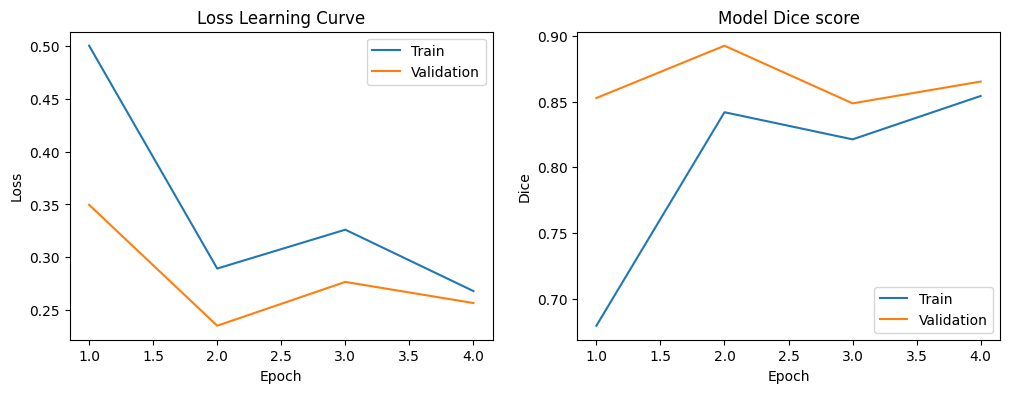

In [196]:
plot_learning_curves(history_paper)

Found 6 poorly segmented images (dice < 0.7):
data_masks/IITD_dataset\019\10.bmp => dice=0.591


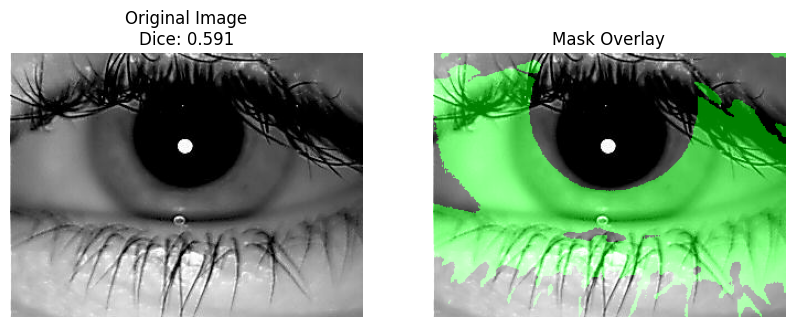

data_masks/IITD_dataset\019\03.bmp => dice=0.597


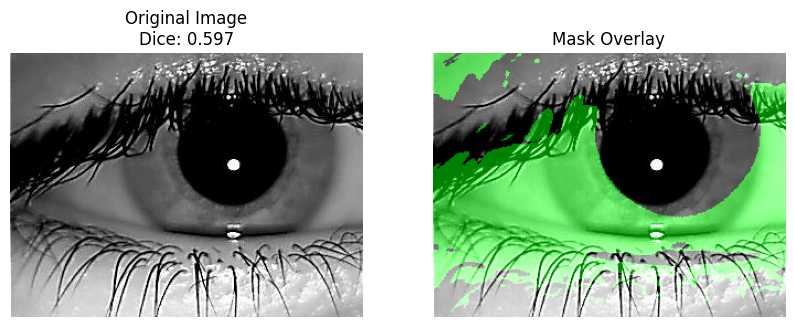

data_masks/IITD_dataset\020\06.bmp => dice=0.692


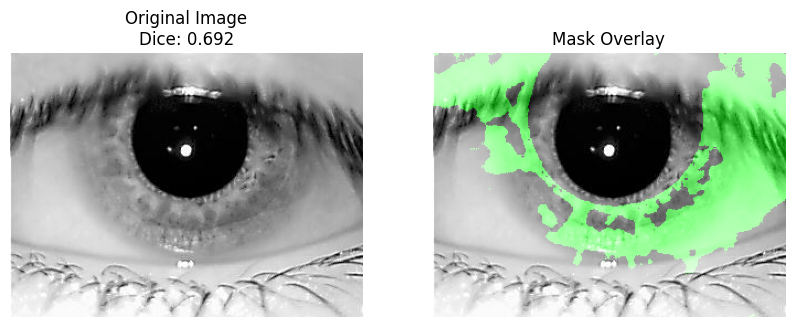

data_masks/IITD_dataset\020\04.bmp => dice=0.652


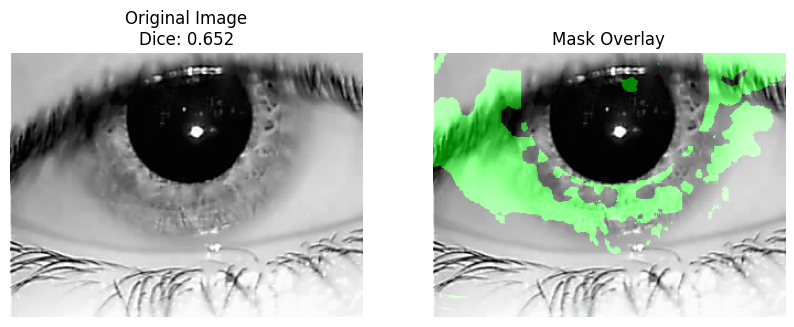

data_masks/IITD_dataset\019\04.bmp => dice=0.619


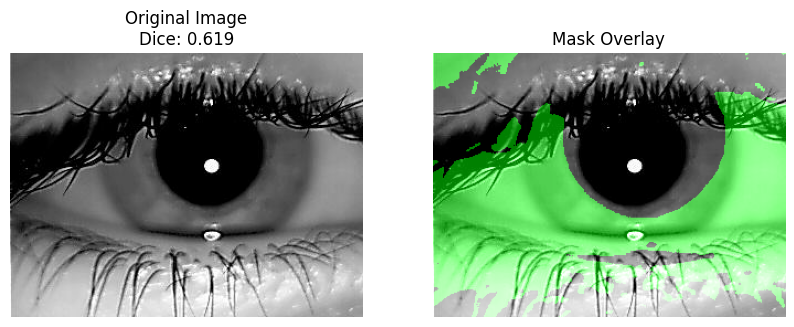

data_masks/IITD_dataset\135\05.bmp => dice=0.692


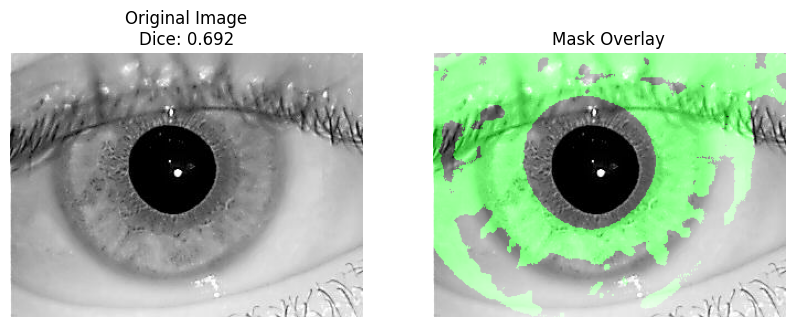

In [197]:
poorly_segmented_images = evaluate_segmentation_per_image(
    val_pairs, model_paper, threshold=0.5, dice_threshold=0.70
)

## tHE REAL DEAL

In [2]:
CSV_FILE = "./data/iris_thousands.csv"
BASE_DIR = "./data/CASIA-Iris-Thousand/"
NUM_CLASSES = 2000
IMAGE_WIDTH = 640    
IMAGE_HEIGHT = 480
IMAGE_CHANNELS = 1
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SIZE_CHANNELS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 24

In [3]:
def update_paths(csv_file, base_dir):
    iris_df = pd.read_csv(csv_file)
    
    corrected_paths = []
    missing_files = []

    for index, row in iris_df.iterrows():
        label = row['Label']  # Assuming 'Label' column contains the format "<subject_id>-<L/R>"
        image_filename = os.path.basename(row['ImagePath'])  # Extract the image file name
        subject_id, eye = label.split("-")  # Split into subject ID and eye (L/R)
        corrected_path = os.path.join(base_dir, subject_id, eye, image_filename)
        corrected_paths.append(corrected_path)

        # Check if the file exists
        if not os.path.exists(corrected_path):
            missing_files.append(corrected_path)

    # Add a new column "Images" to the dataset with the corrected paths
    iris_df["ImagesPath"] = corrected_paths

    # Check and print status of the file paths
    if not missing_files:
        print("All image paths are valid and exist in the dataset directory.")
    else:
        print(f"{len(missing_files)} missing image(s) found:")
        for file in missing_files:
            print(file)

    iris_df.to_csv(csv_file, index=False)
    print(f"Updated dataset saved to: {csv_file}")
    return iris_df

iris_data = update_paths(CSV_FILE, BASE_DIR)

All image paths are valid and exist in the dataset directory.
Updated dataset saved to: ./data/iris_thousands.csv


In [4]:
def check_class_distribution(dataset):
    class_counts = dataset['Label'].value_counts()
    print(class_counts)

    # Check for imbalances
    if class_counts.min() != class_counts.max():
        print("Class distribution is imbalanced.")
    else:
        print("Class distribution is balanced.")

check_class_distribution(iris_data)

Label
437-R    10
700-L    10
149-R    10
241-L    10
241-R    10
         ..
452-L    10
452-R    10
151-L    10
151-R    10
715-L    10
Name: count, Length: 2000, dtype: int64
Class distribution is balanced.


""
def check_image_dimensions(dataset, image_size):
    incorrect_dimensions = []
    for image_path in dataset["ImagesPath"]:
        img = Image.open(image_path)
        if img.size != image_size[:2]:  # Check width and height
            incorrect_dimensions.append((image_path, img.size))

    if incorrect_dimensions:
        print(f"{len(incorrect_dimensions)} image(s) with incorrect dimensions:")
        for file, size in incorrect_dimensions:
            print(f"{file} has size {size}")
    else:
        print("All images have correct dimensions.")

check_image_dimensions(iris_data, IMAGE_SIZE)
""

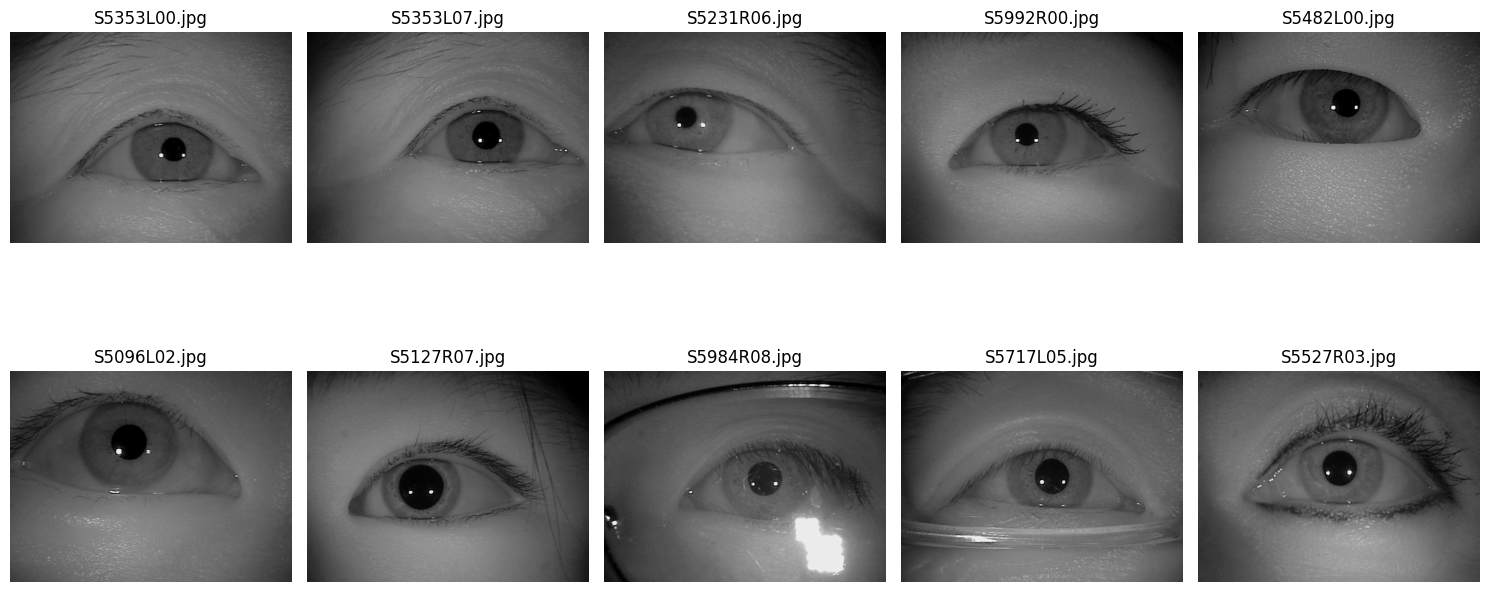

In [5]:
def visualize_images(dataset, num_images):
    sample_images = dataset.sample(num_images)["ImagesPath"].tolist()
    plt.figure(figsize=(15, 8))
    
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        
        # Convert to grayscale if necessary
        if IMAGE_CHANNELS == 1:
            img = img.convert("L")
        
        # Add the image to the plot
        plt.subplot(2, (num_images + 1) // 2, i + 1)  # Dynamically create a grid
        plt.imshow(img, cmap="gray" if IMAGE_CHANNELS == 1 else None)
        plt.title(os.path.basename(image_path))
        plt.axis("off")
    
    # Display the images
    plt.tight_layout()
    plt.show()

# Visualize 10 random images
visualize_images(iris_data, num_images=10)

In [6]:
def label_to_int(label_str):
    """
    label_str is something like '437-R' or '437-L'
    We want to produce 4370 if it's '437-R', or 4371 if it's '437-L'.
    """
    subject_str, side = label_str.split("-")  # e.g. ("437", "R")
    
    subject_id = int(subject_str)  # convert "437" to integer 437
    if side == 'R':
        # Append 0
        return subject_id * 10  # e.g., 437 -> 4370
    elif side == 'L':
        # Append 1
        return subject_id * 10 + 1
    else:
        # Fallback if there's an unexpected side
        raise ValueError(f"Unexpected side: {side} in label {label_str}")


In [7]:
iris_data["LabelIndex"] = iris_data["Label"].apply(label_to_int)


In [8]:
iris_data.head(3)

,Unnamed: 0,Label,ImagePath,ImagesPath,LabelIndex
0,0,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R06.jpg,4370
1,1,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R09.jpg,4370
2,2,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...,./data/CASIA-Iris-Thousand/437\R\S5437R07.jpg,4370


In [9]:
import random

def stratified_split(df, label_col="LabelIndex", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """
    Manually splits the dataframe df into train/val/test 
    while preserving the proportion of each label.
    """
    # Sanity check
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-8, "Ratios must sum to 1."
    
    # We will store rows for each split in these lists
    train_rows = []
    val_rows = []
    test_rows = []
    
    # Set random seed for reproducibility
    random.seed(seed)
    
    # 1) Group by each unique label
    unique_labels = df[label_col].unique()
    
    for label in unique_labels:
        # Extract all rows for this label
        label_df = df[df[label_col] == label]
        
        # Convert to list of row indices or (index, row) pairs
        label_data = list(label_df.itertuples(index=False))
        
        # 2) Shuffle
        random.shuffle(label_data)
        
        # 3) Determine cut points
        n = len(label_data)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        # n_test will be n - n_train - n_val
        
        train_part = label_data[:n_train]
        val_part   = label_data[n_train:n_train + n_val]
        test_part  = label_data[n_train + n_val:]
        
        # Extend the corresponding split lists
        train_rows.extend(train_part)
        val_rows.extend(val_part)
        test_rows.extend(test_part)
    
    # 4) Build final DataFrames
    # The row in 'label_data' is a namedtuple with the columns of df. 
    # We can reassemble them into dictionaries, then create DataFrame.
    train_df = pd.DataFrame(train_rows, columns=df.columns)
    val_df   = pd.DataFrame(val_rows,   columns=df.columns)
    test_df  = pd.DataFrame(test_rows,  columns=df.columns)
    
    return train_df, val_df, test_df

# Usage:
train_df, val_df, test_df = custom_stratified_split(
    iris_data, 
    label_col="LabelIndex", 
    train_ratio=0.8, 
    val_ratio=0.1, 
    test_ratio=0.1,
    seed=42
)

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))




Train size: 16000
Val size:   2000
Test size:  2000
